In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install PyWavelets

In [7]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))  # Ensure unique and sorted IDs

print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [8]:
import numpy as np
import scipy.io
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

sampling_rate = 256

# Define frequency bands
alpha_band = (8, 13)
theta_band = (4, 8)
low_beta_band = (13, 20)
delta_band = (0.5, 4)

# Selected channels (convert to 0-indexed)
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]

# Power function using CWT
def compute_power_cwt(signal, scales, wavelet):
    coeffs, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coeffs) ** 2  # Power

# Initialize list for relative power features
all_relative_features = []

# Main loop
for participant in train_participants:
    file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(file_path)
    participant_data = data['train_data']

    trial_duration = 1.5
    segment_duration = 20
    trials_per_segment = int(segment_duration / trial_duration)
    window_duration = 5
    window_length = window_duration * sampling_rate
    overlap = 0.5
    step_size = int(window_length * (1 - overlap))

    for start in range(0, participant_data.shape[2] - trials_per_segment + 1, trials_per_segment):
        segment_data = participant_data[:, selected_channels, start:start + trials_per_segment]
        segment_signal = segment_data.reshape(-1, segment_data.shape[1])
        segment_signal = segment_signal[:20 * sampling_rate, :]

        for i in range(0, len(segment_signal) - window_length + 1, step_size):
            window_signal = segment_signal[i:i + window_length, :]

            wavelet = 'cmor1.0-0.5'
            scales_alpha = pywt.frequency2scale(wavelet, np.array(alpha_band) / sampling_rate)
            scales_beta = pywt.frequency2scale(wavelet, np.array(low_beta_band) / sampling_rate)
            scales_theta = pywt.frequency2scale(wavelet, np.array(theta_band) / sampling_rate)
            scales_delta = pywt.frequency2scale(wavelet, np.array(delta_band) / sampling_rate)

            window_features = []

            for channel in range(len(selected_channels)):
                alpha = compute_power_cwt(window_signal[:, channel], scales_alpha, wavelet).sum()
                low_beta = compute_power_cwt(window_signal[:, channel], scales_beta, wavelet).sum()
                theta = compute_power_cwt(window_signal[:, channel], scales_theta, wavelet).sum()
                delta = compute_power_cwt(window_signal[:, channel], scales_delta, wavelet).sum()

                total_power = alpha + low_beta + theta + delta + 1e-10  # Avoid divide-by-zero
                relative_alpha = alpha / total_power
                relative_low_beta = low_beta / total_power
                relative_theta = theta / total_power
                relative_delta = delta / total_power

                window_features.append([relative_low_beta, relative_alpha, relative_delta, relative_theta])

            # Average across channels
            window_features = np.mean(window_features, axis=0)
            all_relative_features.append(window_features)

# Convert to numpy array
features = np.array(all_relative_features)

In [9]:
from sklearn.preprocessing import StandardScaler
import joblib

#Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Save the scaler for later use
scaler_path = "/content/drive/MyDrive/Dataset/model/DBSCAN_combined_relative_powers_Scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to /content/drive/MyDrive/Dataset/model/DBSCAN_combined_relative_powers_Scaler.pkl


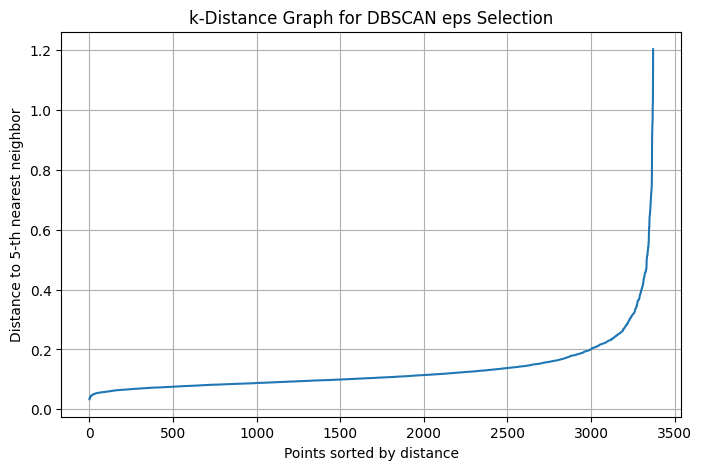

In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(normalized_features)
distances, _ = nbrs.kneighbors(normalized_features)

# Sort the distances and plot
k_distances = distances[:, -1]  # Distance to the k-th neighbor
k_distances_sorted = np.sort(k_distances)

plt.figure(figsize=(8, 5))
plt.plot(k_distances_sorted)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
plt.title('k-Distance Graph for DBSCAN eps Selection')
plt.grid(True)
plt.show()

The elbow appears around a 5th nearest neighbor distance of approximately 0.25.

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

eps = 0.25
min_samples = 5

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(normalized_features)

# Count the number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters >= 2:
    sil_score = silhouette_score(normalized_features, labels)
    dbi_score = davies_bouldin_score(normalized_features, labels)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {dbi_score:.4f}")
else:
    sil_score = dbi_score = float('nan')  # Not valid for < 2 clusters
    print("Not enough clusters to compute Silhouette or DBI (need at least 2 clusters).")


Silhouette Score: 0.2488
Davies-Bouldin Index: 2.0512


Estimated number of clusters: 4
Estimated number of noise points: 134
Cluster distribution: [ 134 3206   17    4   11]


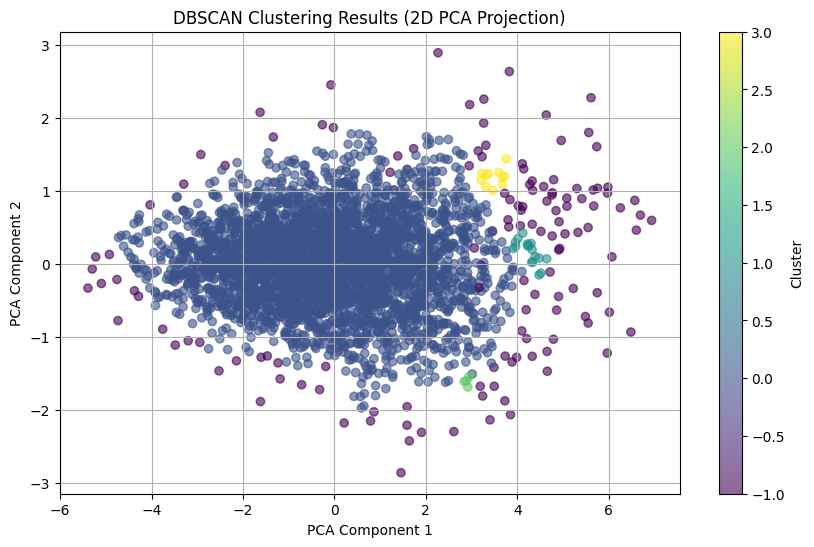

In [14]:
optimal_eps = 0.25
min_samples = 5

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples)
clusters = dbscan.fit_predict(normalized_features)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")
print(f"Cluster distribution: {np.bincount(clusters + 1)}")  # +1 to shift -1 to 0

# Visualize the clusters (using PCA for 2D projection)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(normalized_features)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering Results (2D PCA Projection)')
plt.grid()
plt.show()